In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import cv2

from IPython import display
plt.ion()

# if gpu is to be used
device = torch.device("cpu")

In [2]:
matplotlib.rcParams.update({'font.size': 22})

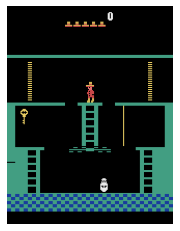

In [5]:
env = gym.make("MontezumaRevenge-v0")
env.reset()


plt.imshow(env.ale.getScreenRGB2())
plt.axis("off")
plt.show()

In [3]:
def plot_norms(episodes):
    plt.figure(2, figsize=(10,10))
    
    plt.title('Action Prediction $\mu$ and $\pm \sigma$ interval')
    plt.xlabel('L2 Norm of Noise')
    plt.ylabel('Average Reward')
    
    for ep, color, label in episodes:
        x, ys = np.array(list(ep.keys())).astype(np.float), np.array(list(ep.values()))
        
        # normalise to the highest reward
        # y = np.mean(ep[0]) for normalising against the first data point
        #y = np.max([np.mean(ep[k]) for k in ep.keys()])
        #ys = (ys - y) / y
        
        mu = np.mean(ys, axis=1)
        plt.plot(x, mu, label=label, color=color, marker='x')
        stds = np.std(ys, axis = 1)
        #plt.fill_between(x, mu + np.max(ys, axis=1) , mu - np.min(ys, axis=1), alpha=0.2, color=color)
        plt.fill_between(x, mu + stds , mu - stds, alpha=0.2, color=color)
    
    plt.legend(prop={'size': 14})
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.savefig('noise_sigma.pdf', format='pdf', dpi=1000)

def plot_fgsm(episode_durations):
    plt.figure(2, figsize=(10,10))
    
    plt.title('Action Prediction $\mu$ and $\pm \sigma$ interval')
    for kk in ['both', 'goal_only', 'action_only']:
        x, ys = np.array(list(episode_durations[kk].keys())), np.array(list(episode_durations[kk].values()))
        plt.xlabel('$\epsilon$')
        plt.ylabel('Average Reward')
        
        mu = np.mean(ys, axis=1)
        plt.plot(x, mu, label=kk, marker='x')
        stds = np.std(ys, axis = 1)
        plt.fill_between(x, mu + stds , mu - stds, alpha=0.2)
    
    plt.xticks(rotation=-45)
    plt.legend(prop={'size': 14})
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.savefig('fgsm_sigma.pdf', format='pdf', dpi=1000)

In [4]:
def plot_norms_minmax(episodes):
    plt.figure(2, figsize=(10,10))
    
    plt.title('Action Prediction $\mu$ and $min/max$ interval')
    plt.xlabel('L2 Norm of Noise')
    plt.ylabel('Average Reward')
    
    for ep, color, label in episodes:
        x, ys = np.array(list(ep.keys())).astype(np.float), np.array(list(ep.values()))
        
        # normalise to the highest reward
        # y = np.mean(ep[0]) for normalising against the first data point
        #y = np.max([np.mean(ep[k]) for k in ep.keys()])
        #ys = (ys - y) / y
        
        mu = np.mean(ys, axis=1)
        plt.plot(x, mu, label=label, color=color, marker='x')
        stds = np.std(ys, axis = 1)
        plt.fill_between(x, np.max(ys, axis=1) , np.min(ys, axis=1), alpha=0.2, color=color)
    
    plt.legend(prop={'size': 14})
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.savefig('noise_minmax.pdf', format='pdf', dpi=1000)

def plot_fgsm_minmax(episode_durations):
    plt.figure(2, figsize=(10,10))
    
    plt.title('Action Prediction $\mu$ and $\pm \sigma$ interval')
    for kk in ['both', 'goal_only', 'action_only']:
        x, ys = np.array(list(episode_durations[kk].keys())), np.array(list(episode_durations[kk].values()))
        plt.xlabel('$\epsilon$')
        plt.ylabel('Average Reward')
        
        mu = np.mean(ys, axis=1)
        plt.plot(x, mu, label=kk, marker='x')
        stds = np.std(ys, axis = 1)
        plt.fill_between(x, np.max(ys, axis=1) , np.min(ys, axis=1), alpha=0.2, color=color)
    
    plt.xticks(rotation=-45)

    plt.legend(prop={'size': 14})
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.savefig('fgsm_minmax.pdf', format='pdf', dpi=1000)

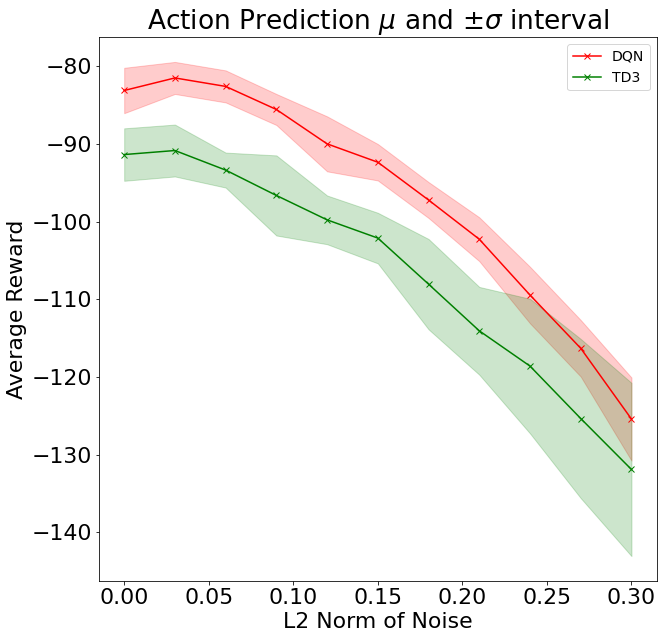

In [48]:
import json
plot_norms([\
    (json.load(open("acrobot/noise/dqn_episodes.json")), "red", "DQN"),\
    #(json.load(open("acrobot/fgsm_targeted/dqn_episodes.json")), "maroon", "DQN (FGSM t)"),\
    (json.load(open("acrobot/noise/td3_episodes.json")), "green", "TD3"),\
    #(json.load(open("acrobot/fgsm_targeted/td3_episodes.json")), "blue", "TD3 (FGSM t)"),\
    #(json.load(open("acrobot/fgsm_untargeted/td3_episodes.json")), "grey", "TD3 (FGSM ut)"),\
    #(json.load(open("acrobot/noise/hiro_episodes.json")), "maroon", "HIRO"),\
   ])

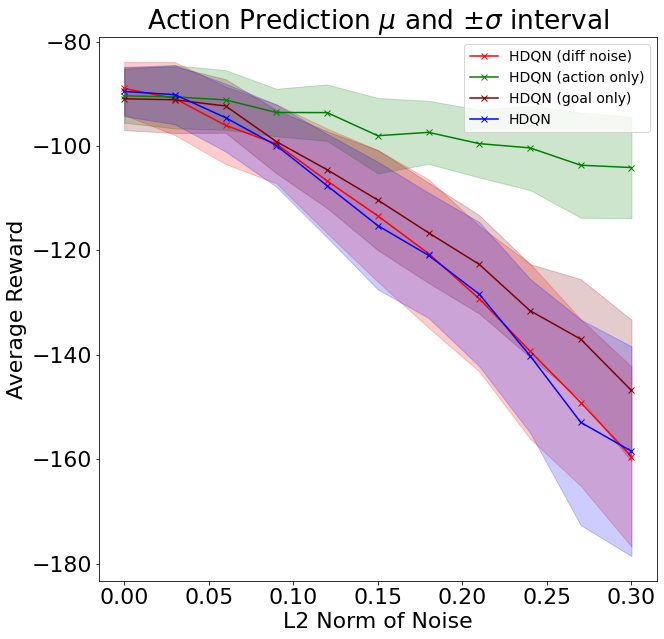

In [27]:
import json
plot_norms([\
    (json.load(open("acrobot/noise_hrl/hdqn_episodes.json"))['both'], "red", "HDQN (diff noise)"),\
    (json.load(open("acrobot/noise_hrl/hdqn_episodes.json"))['action_only'], "green", "HDQN (action only)"),\
    (json.load(open("acrobot/noise_hrl/hdqn_episodes.json"))['goal_only'], "maroon", "HDQN (goal only)"),\
    (json.load(open("acrobot/noise/hdqn_episodes.json")), "blue", "HDQN"),\
    #(json.load(open("acrobot/noise/hiro_episodes.json")), "maroon", "HIRO"),\
   ])

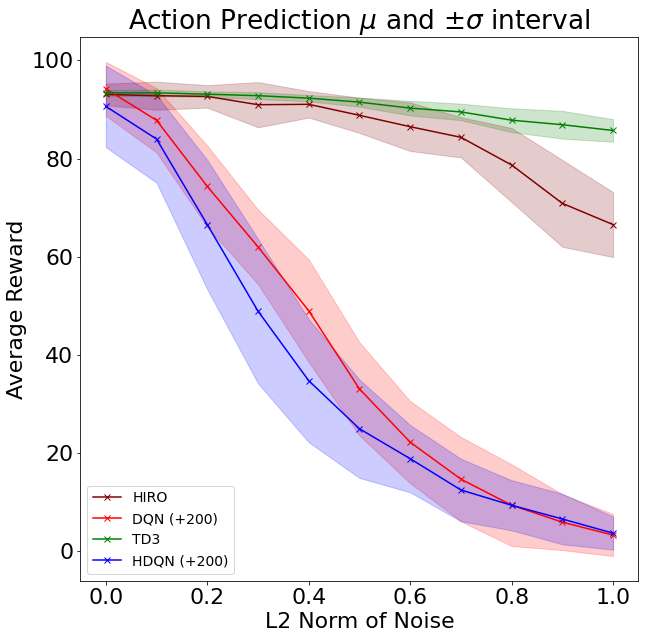

In [13]:
import json
dqn = json.load(open("car/noise/dqn_episodes.json"))
for i in dqn.keys():
    for ii in range(len(dqn[i])):
        dqn[i][ii] += 200

hdqn = json.load(open("car/noise/hdqn_episodes.json"))
for i in hdqn.keys():
    for ii in range(len(hdqn[i])):
        hdqn[i][ii] += 200

plot_norms([\
    (json.load(open("car/noise/hiro_episodes.json")), "maroon", "HIRO"),\
    (dqn, "red", "DQN (+200)"),\
    (json.load(open("car/noise/td3_episodes.json")), "green", "TD3"),\
    (hdqn, "blue", "HDQN (+200)")
   ])

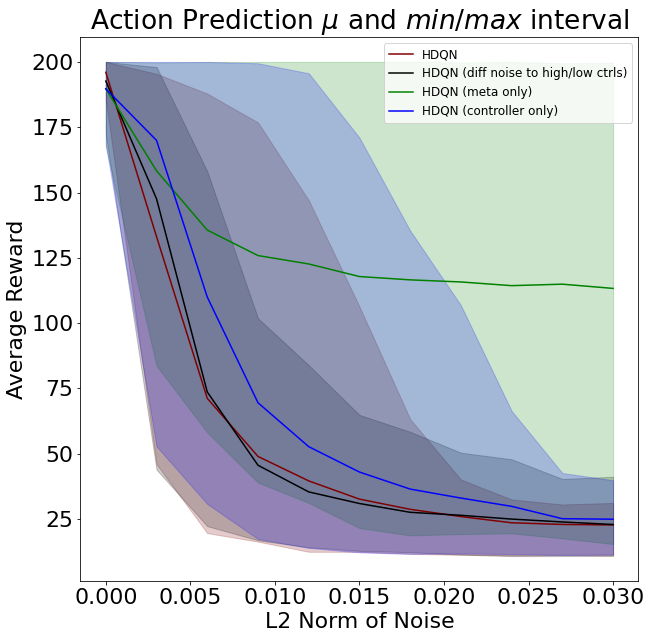

In [24]:
import json
plot_norms_minmax([\
    #(json.load(open("absolute_noise/dqn_episodes.json")), "red", "DQN"),\
    #(json.load(open("absolute_noise/td3_episodes.json")), "green", "TD3"),\
    #(json.load(open("absolute_noise/hiro_episodes.json")), "maroon", "HIRO"),\
    #(json.load(open("absolute_noise_different/hiro_episodes.json")), "black", "HIRO (diff noise to high/low ctrls)"),\
    #(json.load(open("absolute_noise_meta_only/hiro_episodes.json")), "green", "HIRO (meta only)"),\
    #(json.load(open("absolute_noise_ctrl_only/hiro_episodes.json")), "blue", "HIRO (controller only)")
    (json.load(open("absolute_noise/hdqn_episodes.json")), "maroon", "HDQN"),\
    (json.load(open("absolute_noise_different/hdqn_episodes.json")), "black", "HDQN (diff noise to high/low ctrls)"),\
    (json.load(open("absolute_noise_meta_only/hdqn_episodes.json")), "green", "HDQN (meta only)"),\
    (json.load(open("absolute_noise_ctrl_only/hdqn_episodes.json")), "blue", "HDQN (controller only)")
  ])

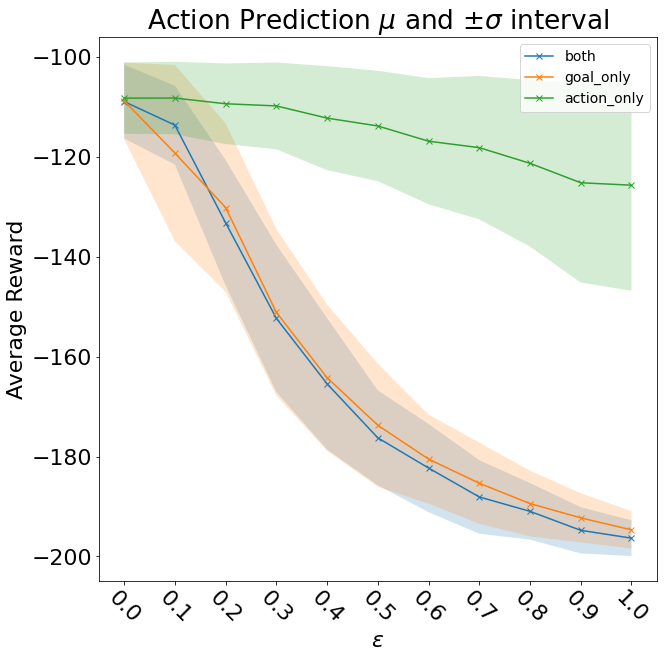

In [25]:
import json
plot_fgsm(json.load(open("car/noise_hrl/hdqn_episodes.json")))

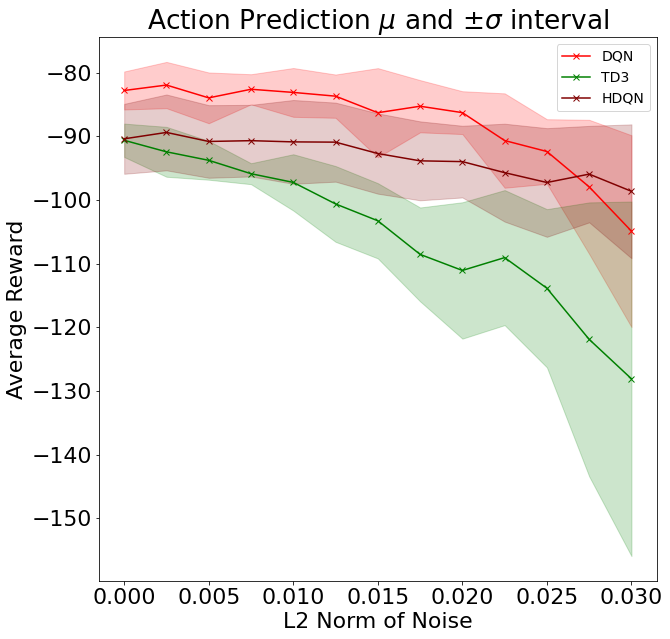

In [58]:
import json
plot_norms([\
    (json.load(open("acrobot/fgsm_targeted/dqn_episodes.json")), "red", "DQN"),\
    (json.load(open("acrobot/fgsm_targeted/td3_episodes.json")), "green", "TD3"),\
    (json.load(open("acrobot/fgsm_targeted/hdqn_episodes.json"))['action_only'], "maroon", "HDQN")
   ])

In [47]:
import json
eps = json.load(open("acrobot/fgsm_untargeted/td3_episodes.json"))
eps_sub = {0.0: [-86.49], 0.0025: [-90.24], 0.005: [-92.97], 0.0075: [-93.18], 0.01: [-94.87], 0.0125: [-93.62], 0.015: [-96.17], 0.0175: [-118.05], 0.02: [-120.8], 0.0225: [-143.29], 0.025: [-200.74], 0.0275: [-227.1], 0.03: [-289.65]}

for i in eps.keys():
    eps[i][2] = eps_sub[float(i)][0]

json = json.dumps(eps)
f = open("td3_episodes.json","w")
f.write(json)
f.close()

In [11]:
hiro1 = {'both': {0.0: [93.8314225698464, 93.92023067366725, 94.53884111025145, 94.01082026783635, 93.48687742316791, 93.91282252589593, 94.3153990968144], 0.025: [92.17632844530289, 93.34774087646333, 94.64143158244802, 93.60997356164573, 93.97629040562319, 94.18258756697816, 93.1867165526663], 0.05: [94.11130100837583, 93.40901651286698, 94.62878026850436, 93.2906246022272, 94.23750783985804, 93.6182783282148, 93.03992394780971], 0.07500000000000001: [88.9313309946977, 93.49406526627003, 94.54752369540225, 93.31618631766722, 94.07826455667599, 93.59474880909913, 92.89143342909671], 0.1: [80.21431033832087, 93.30012491927877, 94.34648252483285, 93.36557139416455, 94.05981512634658, 93.79654089681667, 92.62191497739838], 0.125: [73.13969163422374, 93.37421234607258, 94.01113445761983, 93.22878623801743, 93.65822135317843, 93.2322534255169, 92.1907092516812], 0.15000000000000002: [76.26659475589946, 91.1981647940952, 93.68409850605438, 92.74118526567257, 93.46410811448725, 92.85181701382959, 91.80233296838465], 0.17500000000000002: [29.935284081260683, 71.6461792926723, 93.18060970895799, 90.0871254203134, 93.68750531095183, 91.64791451284995, 91.35006108991801], 0.2: [36.97014612885636, 83.69596438148403, 92.6666168609277, 91.96227527260909, 93.56948344200316, 90.83054956953309, 76.97401078541029], 0.225: [37.532592276477956, 68.38731739335024, 92.66529599933924, 90.81385153907908, 92.72347907723866, 85.33513098003947, 70.86720672281226], 0.25: [40.04614878834503, 70.65389130310373, 91.35153722779408, 84.62213519582953, 92.39786240378858, 89.90810026833981, 74.03517221560045], 0.275: [55.847419959602966, 67.60408149895461, 91.240601480054, 73.60070969353369, 92.05241147276007, 85.3261192148455, 47.650639897358154], 0.30000000000000004: [49.5706450185435, 56.477136106494555, 91.3806237993104, 67.53615170872241, 91.69786233908792, 67.57214214298466, 40.54388739964276]}, 'goal_only': {0.0: [93.91293568381681, 93.71137071411398, 94.55726525181552, 94.1345034901812, 93.85570590457053, 92.94218618577317, 94.02445949652284], 0.025: [92.90948573382737, 92.643012479752, 94.64914903408535, 93.6996939601111, 94.00199484401551, 94.01342374009519, 93.66163185799789], 0.05: [92.0277728563186, 93.71143274429201, 94.61013003297622, 93.72757796442156, 93.9849318798413, 93.88013129248019, 93.3068775245618], 0.07500000000000001: [84.22830292664293, 93.27938770808345, 94.5700588926662, 92.89199256650423, 94.41279540784956, 93.66456843242959, 93.01478908012628], 0.1: [78.29085011081722, 93.27710347401923, 94.39263051828435, 93.31375824914643, 94.02666321509385, 92.62769430203703, 92.17475891986534], 0.125: [78.22363723844127, 93.31216795149801, 94.23744010248986, 92.92379219576944, 94.08557378694559, 93.34142905191312, 92.24996918190962], 0.15000000000000002: [57.06771978990634, 88.9920978641728, 93.82440458747519, 92.73008734554877, 93.8133276980084, 90.12474034958093, 91.9514632396879], 0.17500000000000002: [20.86183588826175, 74.67422706535734, 93.01963688547791, 90.31651544799836, 93.69076264826818, 90.49709808032082, 91.23880342331469], 0.2: [34.22683492313501, 68.48546700908986, 92.39206846832775, 91.96431695197727, 93.53600348893717, 81.00157868266446, 78.05758495289955], 0.225: [37.75409434371617, 61.44398150617264, 91.90410575449089, 91.99268543851403, 93.1852735393575, 85.73919846395944, 73.00262166866962], 0.25: [44.55063979879333, 54.37015446259573, 91.45911549619535, 76.72364939651148, 92.58638179046869, 80.74715231170357, 68.22503789419883], 0.275: [49.94784806064659, 58.547162191373616, 91.07163307318642, 58.39663712608058, 91.93728938842786, 76.75822347502913, 49.818247896794745], 0.30000000000000004: [43.93830914389634, 49.45985017252759, 91.55340736282102, 50.30938872654204, 91.68680345591183, 71.48395980174303, 40.602299080574184]}, 'action_only': {0.0: [94.02433001678769, 94.02252251781391, 94.60227062391198, 93.97466306387031, 93.57608746456904, 94.02791979469652, 94.01021749093056], 0.025: [92.82531924057963, 93.81892122029778, 94.60007744206911, 94.24513349860328, 93.62351049704897, 93.84225988815005, 94.50056309243196], 0.05: [92.99729393387297, 93.57028796114678, 94.65420012448351, 94.02418424146907, 93.75607098579844, 93.91483792969758, 94.1349183517037], 0.07500000000000001: [94.09321850456205, 93.5187122548122, 94.60327743427784, 94.02727206436207, 93.46726591337537, 94.11281690519547, 94.10553485912953], 0.1: [93.88473909864348, 93.99484005974178, 94.58485311724137, 94.21982894669847, 93.78758359970296, 93.86089190985953, 94.06510145264888], 0.125: [93.88633997101505, 93.59909787135352, 94.65015968722619, 94.2268815940769, 93.93352863794011, 93.91606557277589, 94.20808242427852], 0.15000000000000002: [94.02703532774656, 93.48755998284149, 94.65083960771125, 93.9745825930205, 93.69210918084077, 93.84025064160843, 93.92889979335959], 0.17500000000000002: [92.83067669103451, 92.86882654934647, 94.61235728388965, 93.99599749301366, 93.80473271654074, 93.82709852430868, 94.07746505353032], 0.2: [93.65533160239669, 93.5406028191089, 94.62798080371951, 94.26085175780437, 93.56240225022799, 93.75269895518268, 94.21808451616442], 0.225: [93.90424288523792, 93.86837363320967, 94.61328694629707, 94.32223084986622, 93.7948806246513, 93.91233089696414, 93.88529469144248], 0.25: [94.11884709177758, 93.78150462189947, 94.56056817506587, 93.91469319532487, 93.894741725221, 93.90451492622815, 94.12583877279373], 0.275: [93.9909963031579, 94.02386725486544, 94.59882760976377, 94.1406063361252, 93.57655739921405, 94.07978398612622, 94.34499654726604], 0.30000000000000004: [93.92402042480325, 93.76378637670264, 94.6315655330152, 94.19889854342877, 93.5449384269182, 93.88831335562418, 93.97132838236607]}}
hiro2 = {'both': {0.0: [94.65581239573456, 92.66751295860162, 86.62242743271442], 0.025: [94.62823837986264, 92.19800348037879, 89.46198138438696], 0.05: [94.68437191896294, 91.59844014872206, 89.2322777128791], 0.07500000000000001: [94.5267458479354, 91.22928898094948, 89.43479372687081], 0.1: [94.23229243924594, 91.69083195541367, 89.01962934425872], 0.125: [93.8771682160986, 91.04619001625866, 88.81757861165994], 0.15000000000000002: [93.65306888549547, 91.0207930933348, 88.74376190816747], 0.17500000000000002: [93.18806652712509, 90.24393572768659, 88.72404389191149], 0.2: [93.1758649528023, 90.28213235114976, 88.74485048598874], 0.225: [92.6778994586106, 86.28136008164589, 88.7990495816969], 0.25: [92.28091107339243, 80.86364002838398, 88.87912624374654], 0.275: [92.13680546360224, 71.54395190299579, 88.81051879429383], 0.30000000000000004: [88.88953604688015, 56.49340783169192, -15.003525186455638]}, 'goal_only': {0.0: [94.66496683158131, 92.7167902316335, 87.62204297361313], 0.025: [94.63388995793433, 92.11713100313071, 89.35077184379263], 0.05: [94.49777597194367, 91.72862132815693, 88.71640093552273], 0.07500000000000001: [94.26435170285818, 91.09520456654693, 86.40854480272225], 0.1: [94.27916916494416, 91.21495291560237, 89.0609774890319], 0.125: [94.04924962658087, 90.97017957601784, 88.96973595792008], 0.15000000000000002: [93.70947021697769, 90.55369649671924, 88.74698389942272], 0.17500000000000002: [93.43021056655917, 90.47768604882005, 88.73432388054024], 0.2: [93.06388811112782, 87.29151766097348, 88.71945421322069], 0.225: [92.93691694777897, 86.05919770646868, 88.80936507736996], 0.25: [92.55307224472959, 76.69927967152933, 88.88920289504107], 0.275: [92.2056230618204, 65.27993592410779, 88.92128788789027], 0.30000000000000004: [91.23567962173819, 59.90810346785916, -15.061038384689844]}, 'action_only': {0.0: [94.45417464279332, 92.17920115569815, 88.85416414385594], 0.025: [94.57309196515227, 92.21591354035573, 84.61669222719864], 0.05: [94.64678434496336, 92.5627862591971, 85.54904339382469], 0.07500000000000001: [94.57969177812201, 92.61028871885895, 84.5644783487915], 0.1: [94.6223351031618, 92.41385684203847, 84.63204434460644], 0.125: [94.65996735891903, 92.47317017082327, 87.62619736015547], 0.15000000000000002: [94.63808356107651, 92.44749306492055, 88.75387634064069], 0.17500000000000002: [94.58667003140135, 92.30472894056454, 90.7241781768586], 0.2: [94.5269651007118, 92.23908565167898, 86.92506616351828], 0.225: [94.65965016048403, 92.7756064309396, 89.76020713771649], 0.25: [94.34936455380355, 92.80661530235864, 86.81803010691041], 0.275: [94.63280516822749, 92.63740874297892, 86.86167738104417], 0.30000000000000004: [94.64195680337836, 92.1948340611795, 89.60262617611345]}}

In [12]:
hiro = {}
for i in hiro1.keys():
    hiro[i] = {}
    for ii in hiro1[i].keys():
        hiro[i][ii] = list(np.concatenate([hiro1[i][ii], hiro2[i][ii]]))

In [19]:
hiro1 = {0.0: [-94.07, -95.92, -161.92, -92.03, -81.66, -86.68, -94.26, -82.44, -89.55, -86.94], 0.03: [-101.28, -87.51, -90.57, -88.37, -80.78, -91.99, -92.01, -86.09, -94.4, -84.15], 0.06: [-106.55, -89.6, -94.41, -94.66, -83.68, -93.99, -93.82, -88.48, -102.47, -92.38], 0.09: [-113.13, -97.75, -96.38, -99.31, -91.38, -98.38, -96.22, -92.44, -115.87, -93.51], 0.12: [-126.98, -98.23, -102.91, -108.38, -96.59, -104.3, -102.85, -103.32, -125.41, -102.28], 0.15: [-139.33, -101.35, -106.73, -115.51, -110.76, -112.27, -107.53, -104.12, -137.16, -109.8], 0.18: [-135.98, -113.66, -110.95, -124.25, -113.52, -116.05, -110.79, -108.91, -149.37, -119.03], 0.21: [-141.8, -112.5, -119.91, -144.96, -117.71, -124.25, -123.77, -114.01, -156.68, -122.75], 0.24: [-163.26, -120.49, -131.31, -148.31, -134.45, -140.98, -128.29, -122.85, -166.32, -135.55], 0.27: [-180.1, -137.48, -151.21, -176.21, -134.42, -147.82, -140.51, -131.7, -188.78, -143.6], 0.3: [-186.79, -135.37, -160.23, -186.39, -141.64, -156.07, -149.98, -132.57, -187.63, -154.6]}
hiro2 = {0.0: [-91.89], 0.03: [-94.96], 0.06: [-99.97], 0.09: [-101.06], 0.12: [-107.54], 0.15: [-114.63], 0.18: [-117.84], 0.21: [-125.39], 0.24: [-141.21], 0.27: [-148.73], 0.3: [-153.65]}

for i in hiro1.keys():
    #pass
    hiro1[i].pop(2)
    #hiro1[i].pop(12 - 1)
    #hiro1[i].pop(13 - 2)
    #hiro1[i].pop(16 - 3)
    #hiro1[i].pop(17 - 4)
    #hiro1[i][ii].pop(18 - 4)
    #hiro2[i][ii].pop(0)
    #hiro2[i] = np.array(hiro2[i])[[0, 1, 2, 3, 7, 8, 11]]

hiro = {}
for i in hiro1.keys():
    all_i = list(np.concatenate([hiro1[i], hiro2[i]]))
    hiro[i] = all_i

import json
json = json.dumps(hiro)
f = open("hdqn_episodes.json","w")
f.write(json)
f.close()

In [55]:
import json
eps = {'both': {0.0: [-95.42, -86.81, -138.19, -92.18, -76.88, -86.79, -92.76, -83.74, -89.99, -87.48, -96.63], 0.0025: [-97.86, -87.41, -137.33, -90.22, -79.28, -87.72, -92.62, -79.24, -94.69, -82.09, -90.01], 0.005: [-99.11, -91.32, -115.66, -103.11, -80.49, -90.01, -93.18, -79.94, -99.06, -88.69, -93.62], 0.0075: [-100.9, -89.73, -92.43, -101.49, -79.81, -91.28, -86.52, -80.18, -98.52, -88.17, -89.56], 0.01: [-96.07, -87.38, -98.21, -127.77, -95.2, -95.2, -91.32, -81.33, -104.08, -90.4, -97.7], 0.0125: [-114.32, -89.41, -94.78, -134.6, -88.25, -104.52, -93.53, -81.97, -105.25, -96.2, -99.27], 0.015: [-119.39, -93.05, -95.29, -136.2, -91.94, -129.98, -93.21, -88.91, -111.85, -98.06, -100.22], 0.0175: [-114.82, -95.79, -101.12, -132.13, -98.94, -119.49, -100.48, -91.72, -115.45, -103.77, -103.49], 0.02: [-117.03, -94.04, -104.66, -148.44, -108.25, -114.03, -99.34, -101.1, -117.83, -108.11, -105.86], 0.0225: [-127.63, -96.43, -108.53, -142.31, -111.32, -116.94, -100.84, -105.22, -124.74, -143.65, -101.58], 0.025: [-122.41, -100.07, -116.84, -134.85, -113.51, -123.98, -102.28, -103.73, -149.51, -157.32, -105.11], 0.0275: [-124.3, -97.06, -129.0, -126.81, -142.27, -116.82, -104.03, -103.14, -185.92, -164.52, -105.71], 0.03: [-146.24, -112.42, -128.89, -128.34, -165.85, -123.29, -107.4, -102.56, -170.94, -167.65, -106.83]}, 'goal_only': {0.0: [-92.32, -93.01, -152.67, -92.75, -82.45, -89.26, -93.69, -82.29, -89.85, -87.79, -94.79], 0.0025: [-96.31, -88.03, -143.17, -106.52, -80.96, -90.55, -93.16, -79.42, -93.23, -85.05, -98.65], 0.005: [-94.1, -86.8, -105.78, -114.24, -78.01, -89.63, -90.71, -81.05, -89.04, -89.93, -92.98], 0.0075: [-101.48, -91.83, -107.64, -117.17, -79.6, -99.99, -94.01, -84.23, -92.47, -83.81, -96.06], 0.01: [-91.48, -89.53, -91.67, -128.87, -84.41, -95.6, -90.61, -80.83, -97.27, -84.44, -98.64], 0.0125: [-96.54, -95.19, -91.76, -127.64, -85.81, -125.67, -89.96, -80.92, -97.93, -83.64, -100.1], 0.015: [-102.71, -94.57, -93.55, -137.14, -92.88, -144.72, -93.62, -89.0, -99.12, -86.95, -104.26], 0.0175: [-104.31, -98.65, -94.47, -142.21, -100.04, -118.09, -92.12, -87.88, -105.34, -87.5, -102.71], 0.02: [-115.98, -106.44, -93.03, -156.34, -106.16, -138.61, -100.87, -87.44, -109.0, -104.78, -101.88], 0.0225: [-105.39, -95.93, -90.67, -115.6, -133.1, -159.92, -102.2, -87.51, -121.6, -138.68, -105.43], 0.025: [-102.84, -99.07, -96.23, -114.24, -148.99, -198.87, -106.1, -91.58, -143.53, -150.02, -107.32], 0.0275: [-123.53, -103.61, -94.32, -122.7, -165.37, -243.65, -104.71, -95.08, -139.06, -163.25, -106.08], 0.03: [-123.79, -99.48, -93.5, -109.61, -181.54, -321.58, -106.77, -100.75, -168.19, -139.56, -108.82]}, 'action_only': {0.0: [-99.28, -92.73, -180.74, -90.72, -78.76, -88.72, -95.18, -83.81, -89.29, -93.53, -91.66], 0.0025: [-100.16, -94.33, -144.34, -90.44, -77.36, -87.7, -87.14, -84.46, -92.16, -86.19, -93.67], 0.005: [-95.38, -97.7, -143.47, -92.13, -77.74, -85.01, -94.52, -88.47, -95.5, -88.53, -92.85], 0.0075: [-102.32, -91.2, -181.0, -90.75, -80.09, -89.42, -93.57, -85.19, -93.44, -87.12, -93.47], 0.01: [-100.72, -95.2, -181.27, -97.18, -78.42, -87.51, -90.85, -81.67, -94.54, -88.68, -93.72], 0.0125: [-102.34, -89.08, -161.5, -92.39, -80.13, -86.7, -95.31, -84.52, -98.24, -90.2, -89.99], 0.015: [-97.2, -97.11, -198.74, -100.0, -78.33, -89.78, -94.25, -88.12, -96.23, -87.69, -98.07], 0.0175: [-96.13, -97.45, -176.85, -98.69, -80.03, -86.09, -93.39, -101.69, -99.02, -93.65, -92.12], 0.02: [-96.72, -93.76, -154.36, -100.95, -80.82, -88.03, -93.67, -97.2, -99.51, -96.74, -92.07], 0.0225: [-94.4, -104.02, -163.13, -105.82, -80.3, -87.86, -90.87, -97.61, -104.07, -99.26, -92.61], 0.025: [-96.36, -97.6, -160.66, -109.22, -80.72, -89.08, -92.14, -100.92, -109.3, -103.78, -93.15], 0.0275: [-96.48, -90.59, -186.5, -103.03, -80.42, -94.38, -88.91, -99.78, -108.76, -100.72, -96.04], 0.03: [-95.89, -106.31, -193.1, -110.83, -79.59, -90.73, -90.76, -100.08, -117.32, -102.21, -92.39]}}

for i in eps.keys():
    for ii in eps[i].keys():
        eps[i][ii].pop(2)
json = json.dumps(eps)
f = open("hdqn_episodes.json","w")
f.write(json)
f.close()

In [26]:
import json
# both, goal_only, action_only
eps = {
    'both': {0.0: [-95.87, -80.69, -176.11, -95.85, -80.33, -88.02, -91.96, -87.1, -89.05, -89.23], 0.03: [-102.89, -82.23, -89.74, -87.82, -80.29, -93.19, -95.13, -82.5, -95.46, -96.26], 0.06: [-113.05, -92.02, -93.24, -99.25, -90.72, -92.57, -92.79, -84.92, -102.43, -93.28], 0.09: [-112.24, -98.2, -100.4, -102.28, -90.99, -95.28, -93.62, -89.14, -111.74, -98.72], 0.12: [-117.14, -94.59, -99.55, -110.77, -97.92, -104.23, -98.76, -95.94, -127.93, -108.56], 0.15: [-132.37, -96.76, -106.83, -118.08, -104.19, -108.33, -112.79, -105.01, -139.7, -106.59], 0.18: [-138.63, -105.02, -117.04, -128.56, -110.26, -115.16, -113.73, -104.46, -150.97, -116.58], 0.21: [-145.23, -121.42, -122.6, -146.86, -113.0, -123.31, -122.01, -116.29, -156.36, -125.61], 0.24: [-163.45, -123.18, -136.24, -159.02, -120.72, -136.87, -129.92, -123.58, -167.19, -128.42], 0.27: [-166.1, -135.49, -150.82, -169.28, -137.05, -140.18, -144.1, -126.9, -179.21, -148.03], 0.3: [-176.36, -139.74, -166.48, -183.44, -135.7, -154.91, -157.19, -141.23, -187.39, -156.38]},
    'action_only': {0.0: [-98.69, -95.15, -150.24, -91.47, -81.15, -88.3, -94.94, -82.96, -90.32, -88.51], 0.03: [-96.11, -93.15, -132.66, -96.47, -77.71, -87.25, -91.61, -85.22, -90.98, -87.79], 0.06: [-95.3, -94.3, -165.93, -94.47, -77.75, -90.43, -94.1, -83.56, -96.45, -90.48], 0.09: [-100.31, -89.95, -142.68, -96.68, -83.97, -89.8, -94.35, -92.2, -95.55, -98.61], 0.12: [-94.96, -100.63, -159.73, -94.95, -81.12, -88.4, -94.93, -96.49, -100.06, -92.45], 0.15: [-103.23, -111.78, -195.59, -96.72, -84.09, -94.6, -95.62, -95.14, -106.77, -96.14], 0.18: [-103.06, -96.64, -180.05, -100.57, -84.15, -92.48, -94.05, -97.17, -106.97, -96.82], 0.21: [-112.39, -101.35, -145.18, -102.68, -88.71, -99.3, -93.84, -93.57, -106.86, -98.26], 0.24: [-109.9, -103.75, -157.16, -108.14, -83.64, -95.58, -93.57, -96.23, -111.01, -103.13], 0.27: [-122.49, -103.55, -168.33, -109.88, -83.91, -98.19, -96.78, -98.71, -112.58, -109.95], 0.3: [-123.67, -105.7, -164.21, -110.02, -87.99, -99.03, -97.09, -98.68, -114.27, -107.32]},
    'goal_only': {0.0: [-92.07, -104.27, -136.89, -91.29, -80.37, -87.08, -92.49, -84.88, -91.21, -90.9], 0.03: [-103.91, -87.55, -90.08, -94.64, -81.32, -90.17, -90.09, -85.49, -96.07, -85.57], 0.06: [-95.69, -92.04, -92.09, -91.18, -83.74, -91.46, -89.81, -85.97, -100.8, -92.72], 0.09: [-104.96, -104.37, -98.59, -96.94, -93.61, -97.05, -96.31, -90.49, -109.78, -93.01], 0.12: [-115.44, -93.56, -96.6, -108.42, -96.92, -105.65, -101.09, -96.32, -116.59, -105.63], 0.15: [-127.62, -101.12, -99.56, -112.34, -101.68, -109.85, -105.84, -100.03, -128.06, -106.31], 0.18: [-126.34, -113.6, -107.05, -116.99, -115.45, -120.31, -109.75, -103.7, -139.07, -108.32], 0.21: [-132.65, -117.5, -113.95, -129.0, -120.14, -120.98, -116.96, -106.19, -142.59, -120.53], 0.24: [-138.45, -119.39, -118.89, -140.14, -126.16, -131.86, -127.47, -120.34, -149.93, -133.6], 0.27: [-145.07, -127.8, -132.0, -147.3, -134.95, -134.11, -136.1, -120.95, -162.13, -124.07], 0.3: [-153.9, -136.1, -141.75, -161.18, -135.66, -143.96, -147.32, -127.69, -176.21, -136.93]}
}

eps2 = {
    'both': {0.0: [-91.46], 0.03: [-93.28], 0.06: [-99.33], 0.09: [-103.65], 0.12: [-110.83], 0.15: [-109.97], 0.18: [-122.57], 0.21: [-122.41], 0.24: [-140.41], 0.27: [-145.1], 0.3: [-162.54]},
    'action_only': {0.0: [-92.3], 0.03: [-99.47], 0.06: [-94.77], 0.09: [-94.28], 0.12: [-91.94], 0.15: [-96.1], 0.18: [-101.82], 0.21: [-98.42], 0.24: [-98.57], 0.27: [-100.67], 0.3: [-97.36]},
    'goal_only': {0.0: [-94.85], 0.03: [-96.59], 0.06: [-99.86], 0.09: [-104.94], 0.12: [-105.7], 0.15: [-110.61], 0.18: [-112.61], 0.21: [-120.17], 0.24: [-127.97], 0.27: [-137.54], 0.3: [-149.36]}
}

for i in eps.keys():
    for ii in eps[i].keys():
        eps[i][ii].pop(2)

eps0 = {}
for i in eps.keys():
    eps0[i] = {}
    for ii in eps[i].keys():
        all_i = list(np.concatenate([eps[i][ii], eps2[i][ii]]))
        eps0[i][ii] = all_i

json = json.dumps(eps0)
f = open("hdqn_episodes.json","w")
f.write(json)
f.close()

In [30]:
epis = """100; -476.09; 0.5631904013516663
150; -497.15; 0.9532781935845369
200; -484.33; 0.9894144510627282
250; -399.5; 0.964190565461794
300; -277.52; 0.9349262356557952
350; -206.29; 0.9174055483389674
400; -171.45; 0.9351926061143417
450; -144.16; 0.9564917617769069
500; -123.29; 0.9653081892449172
550; -118.58; 0.97179615083517
600; -125.95; 0.959862204252623
650; -130.04; 0.9488360025214245
700; -134.31; 0.9331153435843541
750; -157.14; 0.8916318025628668
800; -227.82; 0.8337243613582689
850; -331.2; 0.7752187892933794
900; -405.43; 0.77"""

dat = {
    'eps': [],
    'reward': [],
    'coop': []
}
for e in epis.split("\n"):
    s = e.split(";")
    dat['eps'].append(int(s[0]))
    dat['reward'].append(float(s[1]))
    dat['coop'].append(float(s[2]))

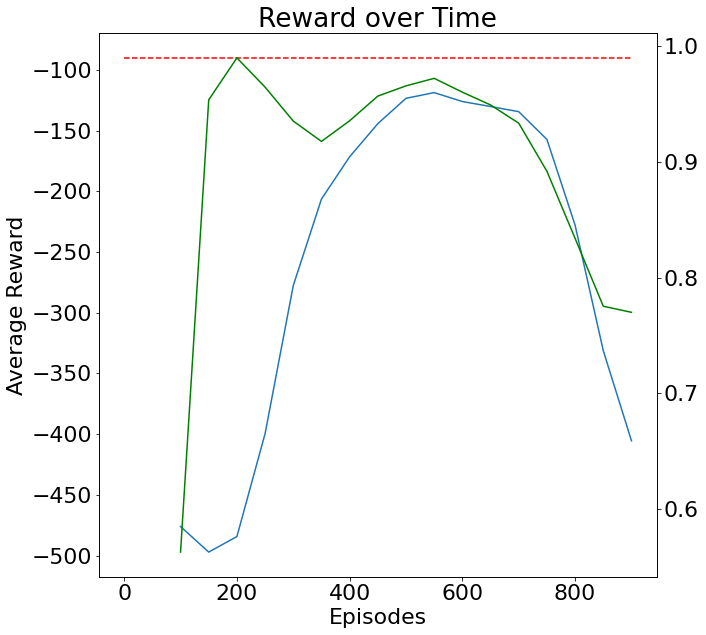

In [31]:
fig, ax = plt.subplots(figsize=(10,10))
    
plt.title('Reward over Time')
plt.xlabel('Episodes')
plt.ylabel('Average Reward')

ax.plot(dat['eps'], dat['reward'], label='reward')
ax.plot([0, dat['eps'][-1]], [-90, -90], color='red', linestyle='dashed')

ax2 = ax.twinx()
ax2.plot(dat['eps'], dat['coop'], color='green')

plt.show()

***
Things for making gifs:

In [ ]:
# tricks to make rendering work in Colab
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

In [ ]:
# goal: 0 to 1; action: 0 to 1
def append_action_goal_to_screen(img, goal, action):
    img = np.array(img[:,::-1])
    max_width = 100
    height = 50

    # omit these two lines for HIRO
    goal = goal * 2 - 1
    action = action * 2 - 1

    if goal < 0:
        cv2.rectangle(img, (int(max_width + goal * max_width), 0), (max_width, height), (255, 0, 0), -1) # goal
    else:
        cv2.rectangle(img, (max_width, 0), (int(max_width + goal * max_width), height), (255, 0, 0), -1) # goal
    if action < 0:
        cv2.rectangle(img, (int(max_width + action * max_width), height), (max_width, 2 * height), (0, 0, 255), -1) # action
    else:
        cv2.rectangle(img, (max_width, height), (int(max_width + action * max_width), 2 * height), (0, 0, 255), -1) # action
    return img

In [ ]:
def render_single_episode(hdqnAgent): # HDQN
    hdqnAgent.eval()
    hdqnAgent.meta_controller.eval()
    hdqnAgent.controller.eval()

    max_episode_length = 200
    num_episodes = 100

    frames = []

    overall_reward = 0
    observation = env.reset()

    state = torch.from_numpy(observation).float().unsqueeze(0).to(device)

    episode_steps = 0
    done = False
    while not done:
        # select a goal
        goal = hdqnAgent.select_goal(state)
        goal_i = goal.item()
        encoded_goal = torch.from_numpy(one_hot(2, goal)).float().to(device)

        goal_done = False
        while not done and not goal_done:
            joint_goal_state = torch.cat([encoded_goal, state], axis=1)

            action = hdqnAgent.select_action(joint_goal_state)
            action_i = action.item()

            frames.append(append_action_goal_to_screen(env.render(mode="rgb_array"), goal_i, action_i))

            observation, reward, done, _ = env.step(action_i)

            overall_reward += reward

            if max_episode_length and episode_steps >= max_episode_length - 1:
                done = True
            episode_steps += 1

            goal_done = (goal_i == action_i)

            state = torch.from_numpy(observation).float().unsqueeze(0).to(device)
    return frames, overall_reward

In [ ]:
def render_single_episode(agent): #HIRO
    agent.eval()
    agent.meta_controller.eval()
    agent.controller.eval()

    max_episode_length = 200
    agent.meta_controller.is_training = False
    agent.controller.is_training = False

    num_episodes = 1

    frames = []

    overall_reward = 0
    observation = env.reset()
    # set a large starting angle
    env.state[2] = -env.observation_space.high[2] / 2.0
    observation = np.array(env.state)

    state = torch.from_numpy(observation).float().unsqueeze(0).to(device)

    episode_steps = 0
    done = False
    while not done:
        # select a goal
        goal = agent.select_goal(state, False)

        goal_done = False
        while not done and not goal_done:
            action = agent.select_action(state, goal, False)

            frames.append(append_action_goal_to_screen(env.render(mode="rgb_array"), goal, action))

            observation, reward, done, info = env.step(action.detach().cpu().squeeze(0).numpy())

            next_state = torch.from_numpy(observation).float().unsqueeze(0).to(device)
            next_goal = agent.h(state, goal, next_state)
                              
            overall_reward += reward

            if max_episode_length and episode_steps >= max_episode_length - 1:
                done = True
            episode_steps += 1

            goal_done = agent.goal_reached(state, goal, next_state)

            state = next_state
            goal = next_goal
    return frames, overall_reward

In [ ]:
frames, overall_reward = render_single_episode(agent)
print(overall_reward)

import pickle
with open('frames.pkl', 'wb') as f:
    pickle.dump(frames, f)

In [ ]:
with open('frames.pkl', 'rb') as f:
    frames = pickle.load(f)
with open('openai_gym.gif', 'wb') as f:
    frames = list(map(lambda x: Image.fromarray(x), frames))
    im = Image.new('RGB', frames[0].size)
    im.save(f, save_all=True, append_images=frames)